In [1]:
import requests
import json
import glob
import datetime
from io import StringIO
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('ticks')

In [2]:
# ids (states) for sensor URL parameters
states = 'AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME \
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT \
 WA WI WV WY'.split()

In [3]:
# create network ids from list of state ids
networks = ['AWOS'] + ['{}_ASOS'.format(state) for state in states]

In [4]:
def get_weather(stations, start=pd.Timestamp('2014-01-01'), end=pd.Timestamp('2014-01-31')):
    '''
        fetch weather from MESOnet between start and end dates
    '''
    
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
           "&tz=Etc/UTC&format=comma&latlon=no"
           "&{start:year1=%Y&month1=%m&day1=%d}"
           "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")

    stations = '&'.join('station={}'.format(s) for s in stations)

    weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                           comment='#')
                 .rename(columns={'valid': 'date'})
                 .rename(columns=str.strip)
                 .assign(date=lambda df: pd.to_datetime(df['date']))
                 .set_index(['station', 'date'])
                 .sort_index())
    
    float_cols = ['tmpf', 'relh', 'sped', 'mslp', 'p01i', 'vsby', "gust_mph"]
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="coerce")
    
    return weather

In [5]:
def get_ids(network):
    '''
        get sensor id from network
    '''
    
    url = 'http://mesonet.agron.iastate.edu/geojson/network.php?network={}'
    
    r = requests.get(url.format(network))
    
    md = json_normalize(r.json()['features'])
    
    md['network'] = network
    
    return md

In [6]:
# get sensor ids
ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)

In [7]:
# group ids by network
id_groups = ids.groupby('network')

In [8]:
# create csv files for weather data
import os

os.makedirs("weather", exist_ok=True)

for i, (k, v) in enumerate(id_groups):
    print("{}/{}".format(i, len(networks)), end='\r')
    weather = get_weather(v['id'])
    weather.to_csv("weather/{}.csv".format(k))

/home/gr4vy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


/home/gr4vy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [22]:
weather = pd.concat([
    pd.read_csv(f, parse_dates=['date'], index_col=['station', 'date'])
    for f in glob.glob('weather/*.csv')])

weather.to_hdf("weather.h5", "weather")

In [2]:
weather = pd.read_hdf('weather.h5', 'weather').sort_index()

In [3]:
weather.head()

tmpf   relh  sped  mslp  p01i  vsby  gust_mph  \
station date                                                                  
01M     2014-01-01 00:15:00  33.80  85.86   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:35:00  33.44  87.11   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:55:00  32.54  90.97   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:15:00  31.82  93.65   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:35:00  32.00  92.97   0.0   NaN   0.0  10.0       NaN   

                            skyc1 skyc2 skyc3  
station date                                   
01M     2014-01-01 00:15:00   CLR     M     M  
        2014-01-01 00:35:00   CLR     M     M  
        2014-01-01 00:55:00   CLR     M     M  
        2014-01-01 01:15:00   CLR     M     M  
        2014-01-01 01:35:00   CLR     M     M

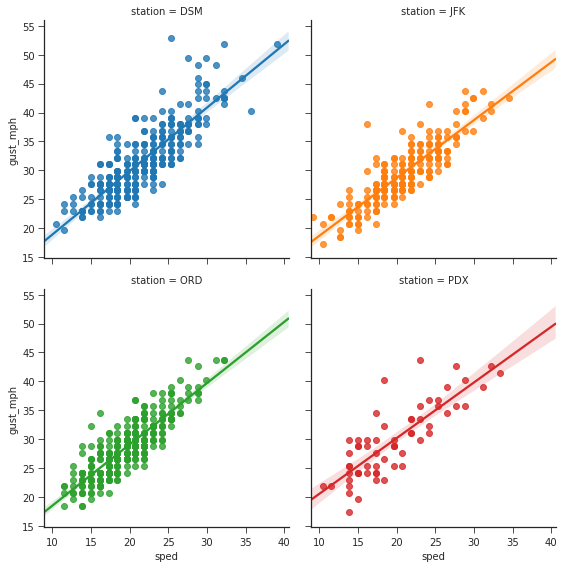

In [4]:
airports = ['DSM', 'ORD', 'JFK', 'PDX']

g =  sns.FacetGrid(weather.sort_index().loc[airports].reset_index(),
                       col='station', hue='station', col_wrap=2, size=4)

g.map(sns.regplot, 'sped', 'gust_mph')

In [5]:
# find the set of airports that we have weather and flight information
flights = pd.read_hdf('flights.h5', 'flights')

weather_locs = weather.index.levels[0]

origin_locs = flights.origin.cat.categories
dest_locs = flights.dest.cat.categories

airports = weather_locs & origin_locs & dest_locs

airports

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'AEX', 'AGS', 'ALB',
       ...
       'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'XNA'],
      dtype='object', length=267)

In [6]:
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')

print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')

print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Weather, no flights:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=1909)

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BKG', 'BQN', 'BRW', 'CDV', 'CLD', 'FAI',
       'FCA', 'GUM', 'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG',
       'OME', 'OTZ', 'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT',
       'STX', 'WRG', 'YAK', 'YUM'],
      dtype='object')

Dropped Stations:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=1943)


In [7]:
# using indexing
weather.loc['DSM'].head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:54:00,10.94,72.79,10.4,1024.9,0.0,10.0,NaN,FEW,M,M
2014-01-01 01:54:00,10.94,72.79,11.5,1025.4,0.0,10.0,NaN,OVC,M,M
2014-01-01 02:54:00,10.94,72.79,8.1,1025.3,0.0,10.0,NaN,BKN,M,M
2014-01-01 03:54:00,10.94,72.79,9.2,1025.3,0.0,10.0,NaN,OVC,M,M
2014-01-01 04:54:00,10.04,72.69,9.2,1024.7,0.0,10.0,NaN,BKN,M,M


In [8]:
# above indexing can be achieved with boolean masks
weather2 = weather.reset_index()
weather2[weather2['station'] == 'DSM'].head()

,station,date,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
884855,DSM,2014-01-01 00:54:00,10.94,72.79,10.4,1024.9,0.0,10.0,NaN,FEW,M,M
884856,DSM,2014-01-01 01:54:00,10.94,72.79,11.5,1025.4,0.0,10.0,NaN,OVC,M,M
884857,DSM,2014-01-01 02:54:00,10.94,72.79,8.1,1025.3,0.0,10.0,NaN,BKN,M,M
884858,DSM,2014-01-01 03:54:00,10.94,72.79,9.2,1025.3,0.0,10.0,NaN,OVC,M,M
884859,DSM,2014-01-01 04:54:00,10.04,72.69,9.2,1024.7,0.0,10.0,NaN,BKN,M,M


In [9]:
# Indexes for Easier Arithmetic, Analysis

In [10]:
# With indices
temp = weather['tmpf']

c = (temp - 32) * 5 / 9
c.to_frame().head()

tmpf
station date                     
01M     2014-01-01 00:15:00   1.0
        2014-01-01 00:35:00   0.8
        2014-01-01 00:55:00   0.3
        2014-01-01 01:15:00  -0.1
        2014-01-01 01:35:00   0.0

In [ ]:
# the above without indices
temp2 = weather.reset_index()[['station', 'date', 'tmpf']]

temp2['tmpf'] = (temp2['tmpf'] - 32) * 5 / 9
temp2.head()

In [12]:
# Indexes for Alignment

In [11]:
dsm = weather.loc['DSM']

hourly = dsm.resample('H').mean()

temp = hourly['tmpf'].sample(frac=.5, random_state=1).sort_index()
sped = hourly['sped'].sample(frac=.5, random_state=2).sort_index()

In [12]:
temp.head().to_frame()

,tmpf
date,
2014-01-01 00:00:00,10.94
2014-01-01 02:00:00,10.94
2014-01-01 03:00:00,10.94
2014-01-01 04:00:00,10.04
2014-01-01 05:00:00,10.04


In [13]:
sped.head()

date
2014-01-01 01:00:00    11.5
2014-01-01 02:00:00     8.1
2014-01-01 03:00:00     9.2
2014-01-01 04:00:00     9.2
2014-01-01 05:00:00    10.4
Name: sped, dtype: float64

In [14]:
# notice above indexes are different (alignment issue)

In [15]:
# pandas automatically aligns indexes in operation below
(sped / temp).head(10)

date
2014-01-01 00:00:00         NaN
2014-01-01 01:00:00         NaN
2014-01-01 02:00:00    0.740402
2014-01-01 03:00:00    0.840951
2014-01-01 04:00:00    0.916335
2014-01-01 05:00:00    1.035857
2014-01-01 06:00:00         NaN
2014-01-01 07:00:00         NaN
2014-01-01 08:00:00         NaN
2014-01-01 09:00:00         NaN
dtype: float64

In [16]:
# use method version of any opertation to include fill_value (instead NaN for missing values)
sped.div(temp, fill_value=1).head(10)

date
2014-01-01 00:00:00     0.091408
2014-01-01 01:00:00    11.500000
2014-01-01 02:00:00     0.740402
2014-01-01 03:00:00     0.840951
2014-01-01 04:00:00     0.916335
2014-01-01 05:00:00     1.035857
2014-01-01 06:00:00     0.093721
2014-01-01 07:00:00    12.700000
2014-01-01 08:00:00     0.083195
2014-01-01 09:00:00     0.091408
dtype: float64

In [17]:
# control axis operation is aligned on
hourly.div(sped, axis='index').head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,0.951304,6.329565,1.0,89.165217,0.0,0.869565,NaN
2014-01-01 02:00:00,1.350617,8.986420,1.0,126.580247,0.0,1.234568,NaN
2014-01-01 03:00:00,1.189130,7.911957,1.0,111.445652,0.0,1.086957,NaN
2014-01-01 04:00:00,1.091304,7.901087,1.0,111.380435,0.0,1.086957,NaN


In [18]:
# abover operations (w/ alignment) --- w/out automagic
temp2 = temp.reset_index()
sped2 = sped.reset_index()

# Find rows where the operation is defined
common_dates = pd.Index(temp2.date) & sped2.date
pd.concat([
    # concat to not lose date information
    sped2.loc[sped2['date'].isin(common_dates), 'date'],
    (sped2.loc[sped2.date.isin(common_dates), 'sped'] /
     temp2.loc[temp2.date.isin(common_dates), 'tmpf'])],
    axis=1).dropna(how='all').head(10)

,date,0
1,2014-01-01 02:00:00,0.740402
2,2014-01-01 03:00:00,0.840951
3,2014-01-01 04:00:00,0.916335
4,2014-01-01 05:00:00,1.035857
8,2014-01-01 13:00:00,NaN
11,2014-01-01 16:00:00,NaN
12,2014-01-01 18:00:00,1.556992
15,2014-01-01 23:00:00,NaN
22,2014-01-02 14:00:00,1.332237
23,2014-01-02 16:00:00,1.160458


In [19]:
# merging DataFrames/Series

In [25]:
# using concat method
pd.concat([sped, temp], axis=1).head()

,sped,tmpf
date,,
2014-01-01 00:00:00,NaN,10.94
2014-01-01 01:00:00,11.5,NaN
2014-01-01 02:00:00,8.1,10.94
2014-01-01 03:00:00,9.2,10.94
2014-01-01 04:00:00,9.2,10.04


In [24]:
pd.concat([sped, temp], axis=1, join='inner').head()

,sped,tmpf
date,,
2014-01-01 02:00:00,8.100,10.94
2014-01-01 03:00:00,9.200,10.94
2014-01-01 04:00:00,9.200,10.04
2014-01-01 05:00:00,10.400,10.04
2014-01-01 13:00:00,13.825,8.96


In [23]:
# using merge method
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True).head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.100
2014-01-01 03:00:00,10.94,9.200
2014-01-01 04:00:00,10.04,9.200
2014-01-01 05:00:00,10.04,10.400
2014-01-01 13:00:00,8.96,13.825


In [26]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True, how='outer').head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.5
2014-01-01 02:00:00,10.94,8.1
2014-01-01 03:00:00,10.94,9.2
2014-01-01 04:00:00,10.04,9.2
